In [1]:
import tensorflow as tf
import os

In [3]:
gpus=tf.config.experimental.list_physical_devices('GPU')#selects the available gpus in the device
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)#tells tf to minimise the gpu usage, sets a limit

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import cv2
import imghdr

In [6]:
data_dir='data'

In [ ]:
os.listdir(os.path.join(data_dir,'happy'))

# Removing dodgy images

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
image_exts= ['jpeg','jpg','bmp','png']
for image_class in os.listdir(data_dir):#gives the classes
    for image in os.listdir(os.path.join(data_dir,image_class)):#gives the path of each image class
        image_path=os.path.join(data_dir,image_class,image)#gives the image path
        try:
            img=cv2.imread(image_path)#load the image in a numpy array
            
            tip=imghdr.what(image_path)#checks the extension
            
            
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print(e)
            print('Issue with image {}'.format(image_path))

# Building the data pipeline

In [9]:
data=tf.keras.utils.image_dataset_from_directory('data')#use keras to load up the data from a irectory

Found 155 files belonging to 2 classes.


In [10]:
data_iterator=data.as_numpy_iterator()#convert the data to a numpy iterator cause the original data is stored in memory as a generator and is not iterable or mutable

In [11]:
batch=data_iterator.next()#lets us access the batches. the keras utility is used to create a data pipeline. basically preprocess the data and also store it into batches. everytime next() is called it returns one batch at atime, if we run it again we will get the next batch

In [12]:
batch[0].shape #images represented as numpy arrays

(32, 256, 256, 3)

In [13]:
batch[1] #labels for each image

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0])

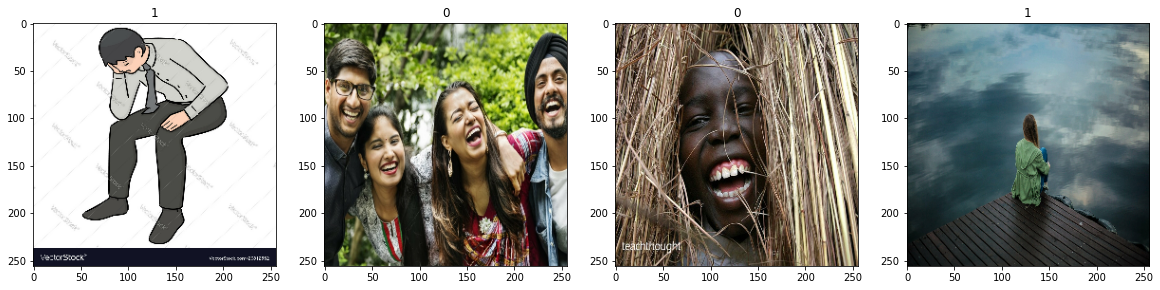

In [14]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))#matplotlib function to create a grid
for idx,img in enumerate(batch[0][:4]):#enumerates adds a indes to the batches
    ax[idx].imshow(img.astype(int))#shows the image in the axis, max=4
    ax[idx].title.set_text(batch[1][idx])#sets the title
    
    #0 FOR HAPPY
    #1 FOR SAD

# Preprocessing

## scaling

In [16]:
data=tf.keras.utils.image_dataset_from_directory('data')#resetablish the data pipeline, since converting the images into int,in the above cell, affects with the values

Found 155 files belonging to 2 classes.


In [17]:
data=data.map(lambda x,y:(x/255,y))#the map function allows the lambda function to be applied on the whole of the batch,all elements, x here represents the images and y the labels, since rgb is 0-255 we scale the image values between 0 and 1 by dividing it by 255

### split data

In [20]:
len(data)#total no. of batches

5

In [21]:
int(5*0.2)

1

In [22]:
train_size=int(len(data)*.7)#size of the training data
val_size=int(len(data)*.2)#size of validation data set
test_size=int(len(data)*.1)+1#size of test data set



In [23]:
test_size+val_size+train_size


5

In [24]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

#the .take is used to take batches of the specified length and skip skipsthe no. of mentioned batched....remember the data must be shuffled.


# The deep learning model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [26]:
model=Sequential()

In [27]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape= (256,256,3)))#convolution layer defines a filter on the input shape
model.add(MaxPooling2D())#returns only the max convolution from the pool

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())#used to flatten the layer to a single d matrixx

model.add(Dense(256,activation='relu'))#fully connected dense layer which returns 256 outputs
model.add(Dense(1,activation='sigmoid'))# the last layer gives a single output

In [28]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])#optimizer for the loss, the loss function for back propagation, and accuracy metrics which will give value in 0 or 1

In [29]:
model.summary()#the 16 in convo layer is the no. of filters
#254,254 is the input shape. maxpoolling takes exactly half pf it, since it has a default pool value of (2,2)
#the parameters increase in every convo layer.
#next comes the flatten layer and then dense layers are applied at last to the flatten layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Train the model

In [31]:
logdir='logs' #select the logs directory

In [32]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)#creates a checkpoint

In [33]:
#training

In [34]:
hist=model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 15s 2s/step - loss: 0.8512 - accuracy: 0.4688 - val_loss: 0.6666 - val_accuracy: 0.6562
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 0.6601 - accuracy: 0.6875 - val_loss: 0.6320 - val_accuracy: 0.5625
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 0.6367 - accuracy: 0.5938 - val_loss: 0.7172 - val_accuracy: 0.4062
Epoch 4/20
3/3 [==============================] - 6s 1s/step - loss: 0.6190 - accuracy: 0.5625 - val_loss: 0.6169 - val_accuracy: 0.7188
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.6222 - accuracy: 0.7812 - val_loss: 0.5657 - val_accuracy: 0.9062
Epoch 6/20
3/3 [==============================] - 6s 1s/step - loss: 0.5594 - accuracy: 0.7188 - val_loss: 0.4763 - val_accuracy: 0.6875
Epoch 7/20
3/3 [==============================] - 6s 2s/step - loss: 0.5362 - accuracy: 0.6562 - val_loss: 0.4181 - val_accuracy: 0.7812
Epoch 8/20
3/3 [========================

In [ ]:
hist.history #since stored as a call back all the informtion is stored in the form of list...so that we can use them to plot the results

# visualise the data

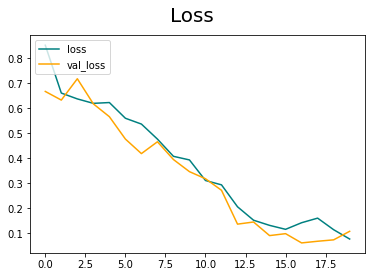

In [37]:
fig=plt.figure()
plt.plot(hist.history['loss'], color='teal',label='loss')
plt.plot(hist.history['val_loss'], color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()
#if the loss decreases and val-loss increases that means data is over fitted use regulatrization
#if loss doesnot decrease model under fitted

# Evaluate

In [39]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy #import the metrices

In [40]:
pre= Precision()
re= Recall()
acc= BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator():
    X,y=batch #list unpacking where X is the images and y are the labels
    yhat=model.predict(X) #yhat returns the labes (y') on the test images
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

In [42]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:0.8333333134651184, accuracy:0.9259259104728699


# Test

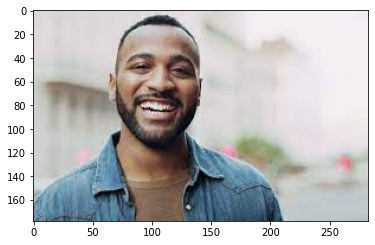

In [29]:
img=cv2.imread(r"C:\Users\SRIJAN\Dropbox\PC\Documents\Programing\Projects\Python\Deep_learning_proj\Binary_image_classifier\test\happy\sadtest3.jpeg")

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))#since cv2 converts the image to BGR colour scale we convert its to rgb
plt.show()

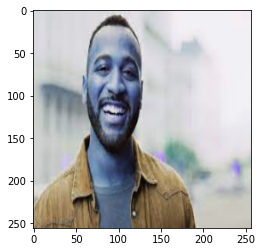

In [30]:
resize=tf.image.resize(img,(256,256))#since the input layer takes inpi=ut in this dimension with 3 channels
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
resize.shape #the shape of our current image is this
#but our model expects images in batches

TensorShape([256, 256, 3])

In [47]:
np.expand_dims(resize,0).shape #adding and extra dimenstion with this feature of numpy

(1, 256, 256, 3)

In [48]:
yhat=model.predict(np.expand_dims(resize/255,0)) #SCALING the value by dividing it by 255

In [49]:
yhat[0][0] #1 for sad 0 for happy

0.5973862

In [50]:
if yhat>0.5:
    print('Prediction is this is a sad person')
else:
    print('Prediction is this is a happy person')

Prediction is this is a sad person


# Save the model

In [ ]:
model.save(os.path.join('models','binaryimageclassifiernewversion.h5')) #run this line again only if you make changes to the model architecture

# Plug and play

In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
#import the dependencies before plug and play


In [1]:
from tensorflow.keras.models import load_model

In [3]:
new_model=load_model(os.path.join('models','binaryimageclassifiernewversion.h5'))
#loading the model basically makes it like a plug and play an api

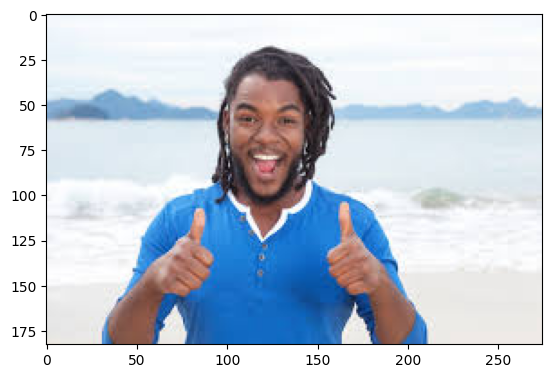

In [2]:
img=cv2.imread(r"C:\Users\SRIJAN\Dropbox\PC\Documents\Programing\Projects\Python\Deep_learning_proj\Binary_image_classifier\test\happy\happytest.jpeg")#load the complete path of the test image 'r' is used to read it as a raw text file
if img.all()=='none':
    print('Corrupted File')
else:
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))#since cv2 converts the image to BGR colour scale we convert its to rgb
    plt.show()


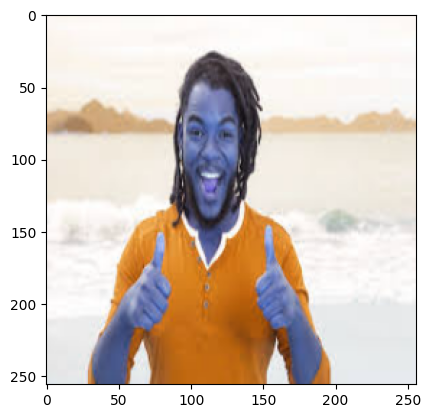

In [6]:
resize=tf.image.resize(img,(256,256))
img2=np.array(resize).astype(int) 
plt.imshow(img2)
plt.show()

In [48]:
yhat=new_model.predict(np.expand_dims(resize/255,0)) #just use the loaded model to predict,divided by 255 to normalise it

In [49]:
if yhat>0.5:
    print('Prediction: this is a sad person')
else:
    print('Prediction: this is a happy person')

Prediction: this is a happy person
